In [ ]:
"""
File Name: trained_model_comparison.ipynb

Description: Evaluation of trained models

Author: junghwan lee
Email: jhrrlee@gmail.com
Date Created: 2023.09.12
Todo:
1. Separation concerns between reshaping dataset and evaluation
"""

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
from tensorflow.keras import backend as K
import time
import math

In [ ]:
trainedmodel_path = '../resource/trained_models/'
data_path = '../resource/dataset/'

In [ ]:
trained_model_cnnlstm = 'cnn_lstm_new2_sum_40_40_86.h5'
trained_model_bilstm_attn = 'v2_1_2_bilstm_attn_new2_sum_40_40_39.h5'
trained_model_lstm = 'v2_1_2_lstm_new2_sum_40_40_94.h5'
trained_model_resnet = 'v2_1_2_resnet_new2_sum_40_40_101.h5'
trained_model_1dcnn = 'v2_2_1dcnn_new2_sum_40_40290.h5'
trained_model_tcn = 'v3_1_2_tcn_new2_sum_40_40_76.h5'
trained_model_transformer = 'v4_1_transformer_new2_sum_40_40_133.h5'

In [ ]:
def get_cyclesum_data_x(start_cycle, num_cycles, X):
  # Select only the data for the specified range of cycles
  X_selected = X[:, :, start_cycle:start_cycle+num_cycles]
  # Print shapes of the returned arrays
  print(f"Shape of X: {X_selected.shape}")

  return X_selected

In [ ]:
def get_RUL(eol, num_cycles):
  return eol - num_cycles

In [ ]:
import tensorflow as tf
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # some small constant
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [ ]:
# Load the original data
eol = np.load(data_path + 'eol.npy')
cycle_data_dis = np.load(data_path + 'cycle_data_dis.npy')
indices_train = np.load(data_path + 'train_indices.npy')
indices_val = np.load(data_path + 'val_indices.npy')
indices_test = np.load(data_path + 'test_indices.npy')
new_cycle_sum = np.load(data_path + 'new_cycle_sum.npy')

num_cells = eol.shape[0]
num_cycles = cycle_data_dis.shape[1]
cycle_count = np.arange(1, num_cycles+1)
RUL = eol - num_cycles

print("RUL shape:", RUL.shape)
print("cycle_data_dis shape:", cycle_data_dis.shape)
print("new_cycle_sum shape:", new_cycle_sum.shape)

RUL shape: (124, 1)
cycle_data_dis shape: (114, 100, 4, 500)
new_cycle_sum shape: (124, 14, 100)


In [ ]:
indices_train = [0, 3, 4, 6, 9, 12, 15, 16, 19, 22, 28, 29, 32, 37, 39, 41, 44, 46, 48, 52, 55, 58, 61, 63, 66, 69, 73, 76, 79, 82, 85, 87, 89, 99, 102, 106, 109, 114, 117, 120, 123]
indices_val = [1, 5, 7, 8, 11, 13, 17, 20, 23, 25, 30, 33, 35, 38, 40, 45, 49, 50, 53, 56, 59, 64, 67, 70, 71, 74, 77, 80, 86, 90, 92, 94, 95, 98, 100, 104, 107, 110, 111, 113, 115, 118, 121]
indices_test = [2, 10, 14, 18, 21, 24, 26, 27, 31, 34, 36, 42, 43, 47, 51, 54, 57, 60, 62, 65, 68, 72, 75, 78, 81, 83, 84, 88, 91, 93, 96, 97, 101, 103, 105, 108, 112, 116, 119, 122]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def rul_sumdata_preparation_with_fixed_indice(cycle_data, rul, indices_train, indices_val, indices_test):

  X = cycle_data.transpose(0,2,1)
  #X = cycle_data
  y = rul

  num_samples, num_cycles, num_features = X.shape
  # The length of each sequence is cycles * time_series
  sequence_length = num_cycles
  X_reshaped = X.reshape(num_samples, sequence_length, num_features)
  y_reshaped = y.reshape(-1, 1)

  print("X X_reshaped:", X.shape, X_reshaped.shape)
  print("y y_reshaped:", y.shape, y_reshaped.shape)
  print("num_features", num_features)
  # normalization
  y_scaler = MinMaxScaler()
  #scalers = [5]
  X_reshaped_norm = np.zeros_like(X_reshaped)
  for i in range(num_features):
    scalers= MinMaxScaler()
    X_reshaped_norm[:, :, i] = scalers.fit_transform(X_reshaped[:, :, i].reshape(-1, 1)).reshape(num_samples, sequence_length)

  y_scaler = MinMaxScaler()
  print("X_reshaped_norm", X_reshaped_norm.shape)
  #y_reshaped_norm = y_scaler.fit_transform(y_reshaped)
  y_reshaped_norm = y_reshaped


  # Split the data based on train, validatioin, test indices
  print("Indices of training set:", indices_train)
  print("Indices of validation set:", indices_val)
  print("Indices of test set:", indices_test)
  X_train, X_val, X_test = X_reshaped[indices_train], X_reshaped[indices_val], X_reshaped[indices_test]
  X_norm_train, X_norm_val, X_norm_test = X_reshaped_norm[indices_train], X_reshaped_norm[indices_val], X_reshaped_norm[indices_test]
  y_train, y_val, y_test  = y_reshaped[indices_train], y_reshaped[indices_val], y_reshaped[indices_test]
  y_norm_train, y_norm_val, y_norm_test = y_reshaped_norm[indices_train], y_reshaped_norm[indices_val], y_reshaped_norm[indices_test]
  print("X_train X_val X_test:", X_train.shape, X_val.shape, X_test.shape)
  print("X_norm_train X_norm_val X_norm_test:", X_norm_train.shape, X_norm_val.shape, X_norm_test.shape)
  print("y_train y_val y_test:", y_train.shape, y_val.shape, y_test.shape)
  print("y_norm_train y_norm_val y_norm_test:", y_norm_train.shape, y_norm_val.shape, y_norm_test.shape)

  return X_train, X_val, X_test, X_norm_train, X_norm_val, X_norm_test, y_train, y_val, y_test, y_norm_train, y_norm_val, y_norm_test

In [ ]:
cycle_data_selected = get_cyclesum_data_x(40, 40, new_cycle_sum)
RUL_selected = get_RUL(eol, 80)

Shape of X: (124, 14, 40)


In [ ]:
X_train, X_val, X_test, X_train_norm, X_val_norm, X_test_norm, y_train, y_val, y_test, y_train_norm, y_val_norm, y_test_norm \
= rul_sumdata_preparation_with_fixed_indice(cycle_data_selected, RUL_selected, indices_train, indices_val, indices_test)

X X_reshaped: (124, 40, 14) (124, 40, 14)
y y_reshaped: (124, 1) (124, 1)
num_features 14
X_reshaped_norm (124, 40, 14)
Indices of training set: [0, 3, 4, 6, 9, 12, 15, 16, 19, 22, 28, 29, 32, 37, 39, 41, 44, 46, 48, 52, 55, 58, 61, 63, 66, 69, 73, 76, 79, 82, 85, 87, 89, 99, 102, 106, 109, 114, 117, 120, 123]
Indices of validation set: [1, 5, 7, 8, 11, 13, 17, 20, 23, 25, 30, 33, 35, 38, 40, 45, 49, 50, 53, 56, 59, 64, 67, 70, 71, 74, 77, 80, 86, 90, 92, 94, 95, 98, 100, 104, 107, 110, 111, 113, 115, 118, 121]
Indices of test set: [2, 10, 14, 18, 21, 24, 26, 27, 31, 34, 36, 42, 43, 47, 51, 54, 57, 60, 62, 65, 68, 72, 75, 78, 81, 83, 84, 88, 91, 93, 96, 97, 101, 103, 105, 108, 112, 116, 119, 122]
X_train X_val X_test: (41, 40, 14) (43, 40, 14) (40, 40, 14)
X_norm_train X_norm_val X_norm_test: (41, 40, 14) (43, 40, 14) (40, 40, 14)
y_train y_val y_test: (41, 1) (43, 1) (40, 1)
y_norm_train y_norm_val y_norm_test: (41, 1) (43, 1) (40, 1)


In [ ]:
def rul_prediction(model, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm):
  start_time = time.time()
  y_train_pred = model.predict(X_train_norm)
  prediction_time = (time.time() - start_time) * 1000
  y_train = y_train_norm
  y_train_pred = np.squeeze(y_train_pred)
  y_train = np.squeeze(y_train)

  # Compute evaluation metrics on the unnormalized predictions
  train_rmse_rul = np.sqrt(mean_squared_error(y_train, y_train_pred))
  train_mae_rul = mean_absolute_error(y_train, y_train_pred)
  train_mape_rul = mean_absolute_percentage_error(y_train, y_train_pred).numpy().item()

  print(f"Train RMSE for RUL: {train_rmse_rul.item()} prediction_time: {prediction_time} MAPE for RUL: {train_mape_rul} MAE for RUL: {train_mae_rul}")

  y_val_pred = model.predict(X_val_norm)
  y_val = y_val_norm
  y_val_pred = np.squeeze(y_val_pred)
  y_val = np.squeeze(y_val)

  # Compute evaluation metrics on the unnormalized predictions
  val_rmse_rul = np.sqrt(mean_squared_error(y_val, y_val_pred))
  val_mae_rul = mean_absolute_error(y_val, y_val_pred)
  val_mape_rul = mean_absolute_percentage_error(y_val, y_val_pred).numpy().item()

  print(f"Validation RMSE for RUL: {val_rmse_rul.item()} MAPE for RUL: {val_mape_rul} MAE for RUL: {val_mae_rul}")

  y_test_pred = model.predict(X_test_norm)
  y_test = y_test_norm
  y_test_pred = np.squeeze(y_test_pred)
  y_test = np.squeeze(y_test)

  # Compute evaluation metrics on the unnormalized predictions
  test_rmse_rul = np.sqrt(mean_squared_error(y_test, y_test_pred))
  test_mae_rul = mean_absolute_error(y_test, y_test_pred)
  test_mape_rul = mean_absolute_percentage_error(y_test, y_test_pred).numpy().item()

  print(f"Test RMSE for RUL: {test_rmse_rul.item()} MAPE for RUL: {test_mape_rul} MAE for RUL: {test_mae_rul}")

  # Create separate DataFrames for each dataset
  train_data = pd.DataFrame({'y_train': y_train, 'y_train_pred': y_train_pred})
  val_data = pd.DataFrame({'y_val': y_val, 'y_val_pred': y_val_pred})
  test_data = pd.DataFrame({'y_test': y_test, 'y_test_pred': y_test_pred})

  mape_score = (train_mape_rul + val_mape_rul + test_mape_rul) / 3
  rmse_score = (train_rmse_rul + val_rmse_rul + test_rmse_rul) / 3
  print(f"rmse_score : {rmse_score} mape score : {mape_score}")
  return y_train_pred, y_val_pred, y_test_pred

In [ ]:
trained_model_resnet = 'v2_1_2_resnet_new2_sum_40_40_101.h5'
trained_model_cnnlstm = 'cnn_lstm_new2_sum_40_40_86.h5'
trained_model_bilstm_attn = 'v2_1_2_bilstm_attn_new2_sum_40_40_39.h5'
trained_model_lstm = 'v2_1_2_lstm_new2_sum_40_40_94.h5'
trained_model_1dcnn = 'v2_2_1dcnn_new2_sum_40_40290.h5'
trained_model_tcn = 'v3_1_2_tcn_new2_sum_40_40_76.h5'
trained_model_transformer = 'v4_1_transformer_new2_sum_40_40_133.h5'

resnet_custom_objects = {"root_mean_squared_error": root_mean_squared_error}
model_resnet = load_model(trainedmodel_path + trained_model_resnet, custom_objects=resnet_custom_objects)


In [ ]:
cnnlstm_custom_objects = {"root_mean_squared_error": root_mean_squared_error}
model_cnnlstm = load_model(trainedmodel_path + trained_model_cnnlstm, custom_objects=cnnlstm_custom_objects)

In [ ]:
bilstm_attn_custom_objects = {"root_mean_squared_error": root_mean_squared_error}
model_bilstm_attn = load_model(trainedmodel_path + trained_model_bilstm_attn, custom_objects=bilstm_attn_custom_objects)

In [ ]:
lstm_custom_objects = {"root_mean_squared_error": root_mean_squared_error}
model_lstm = load_model(trainedmodel_path + trained_model_lstm, custom_objects=lstm_custom_objects)

In [ ]:
#trained_model_1dcnn
custom_objects_1dcnn = {"root_mean_squared_error": root_mean_squared_error}
model_1dcnn = load_model(trainedmodel_path + trained_model_1dcnn, custom_objects=custom_objects_1dcnn)

In [ ]:
!pip install keras-tcn

In [ ]:
from tcn import TCN
tcn_custom_objects = {"root_mean_squared_error": root_mean_squared_error, 'TCN': TCN}
model_tcn = load_model(trainedmodel_path + trained_model_tcn, custom_objects=tcn_custom_objects)

in transformer, weights are saved instead of whole model due to user defined function. </br>
if the user-defined model is written with class for generation of instance then whole model also can be saved. I did to this work due to limited time during test.  </br>
in future, it can be done if there are some requirements. i expect it may take 2 or 3 hours

In [ ]:
import importlib
import transformer_lib
importlib.reload(transformer_lib)
from transformer_lib import create_v4_transformer_model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

In [ ]:
num_heads = 14
input_shape = X_train.shape[1:]
d_model = input_shape[1]
seq_len = input_shape[0]
print(seq_len, d_model)
head_size = d_model//num_heads
if head_size == 0:
  head_size = 1

learning_rate = 0.0001
loss = 'mean_squared_error'
num_encoder = 9
batch_size = 1
dropout = 0.1
ff_dim = 1024
final_dropout = 0
final_activation = 'leaky_relu'

40 14


In [ ]:
model_transformer = create_v4_transformer_model(
    input_shape,
    learning_rate,
    loss,
    num_encoder,
    head_size,
    num_heads,
    ff_dim,
    d_model,
    dropout,
    final_dropout,
    final_activation)

1/1 [==============================] - 1s 610ms/step


In [ ]:
model_transformer.load_weights(trainedmodel_path + trained_model_transformer)

In [ ]:
train_pred_resnet, val_pred_resnet, test_pred_resnet = rul_prediction(model_resnet, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)
train_pred_cnnlstm, val_pred_cnnlstm, test_pred_cnnlstm = rul_prediction(model_cnnlstm, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)
train_pred_bilstm_attn, val_pred_bilstm_attn, test_pred_bilstm_attn = rul_prediction(model_bilstm_attn, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)
train_pred_lstm, val_pred_lstm, test_pred_lstm = rul_prediction(model_lstm, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)
train_pred_1dcnn, val_pred_1dcnn, test_pred_1dcnn = rul_prediction(model_1dcnn, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)
train_pred_tcn, val_pred_tcn, test_pred_tcn = rul_prediction(model_tcn, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)
train_pred_transformer, val_pred_transformer, test_pred_transformer = rul_prediction(model_transformer, X_train_norm, X_val_norm, X_test_norm, y_train_norm, y_val_norm, y_test_norm)


2/2 [==============================] - 0s 28ms/step
Train RMSE for RUL: 65.879835108657 prediction_time: 128.56054306030273 MAPE for RUL: 6.2332979908599855 MAE for RUL: 46.3203835836271
2/2 [==============================] - 0s 36ms/step
Validation RMSE for RUL: 193.92463833786667 MAPE for RUL: 13.409446574298103 MAE for RUL: 111.33531366392623
2/2 [==============================] - 0s 27ms/step
Test RMSE for RUL: 128.02170419971247 MAPE for RUL: 12.637974439283791 MAE for RUL: 85.20046291351318
rmse_score : 129.27539254874537 mape score : 10.760239668147292
2/2 [==============================] - 0s 9ms/step
Train RMSE for RUL: 128.68968165119006 prediction_time: 63.04049491882324 MAPE for RUL: 5.565801149836821 MAE for RUL: 52.71409569717035
2/2 [==============================] - 0s 7ms/step
Validation RMSE for RUL: 189.13916397067482 MAPE for RUL: 13.99823233356399 MAE for RUL: 115.84686137354652
2/2 [==============================] - 0s 6ms/step
Test RMSE for RUL: 166.9382507641004

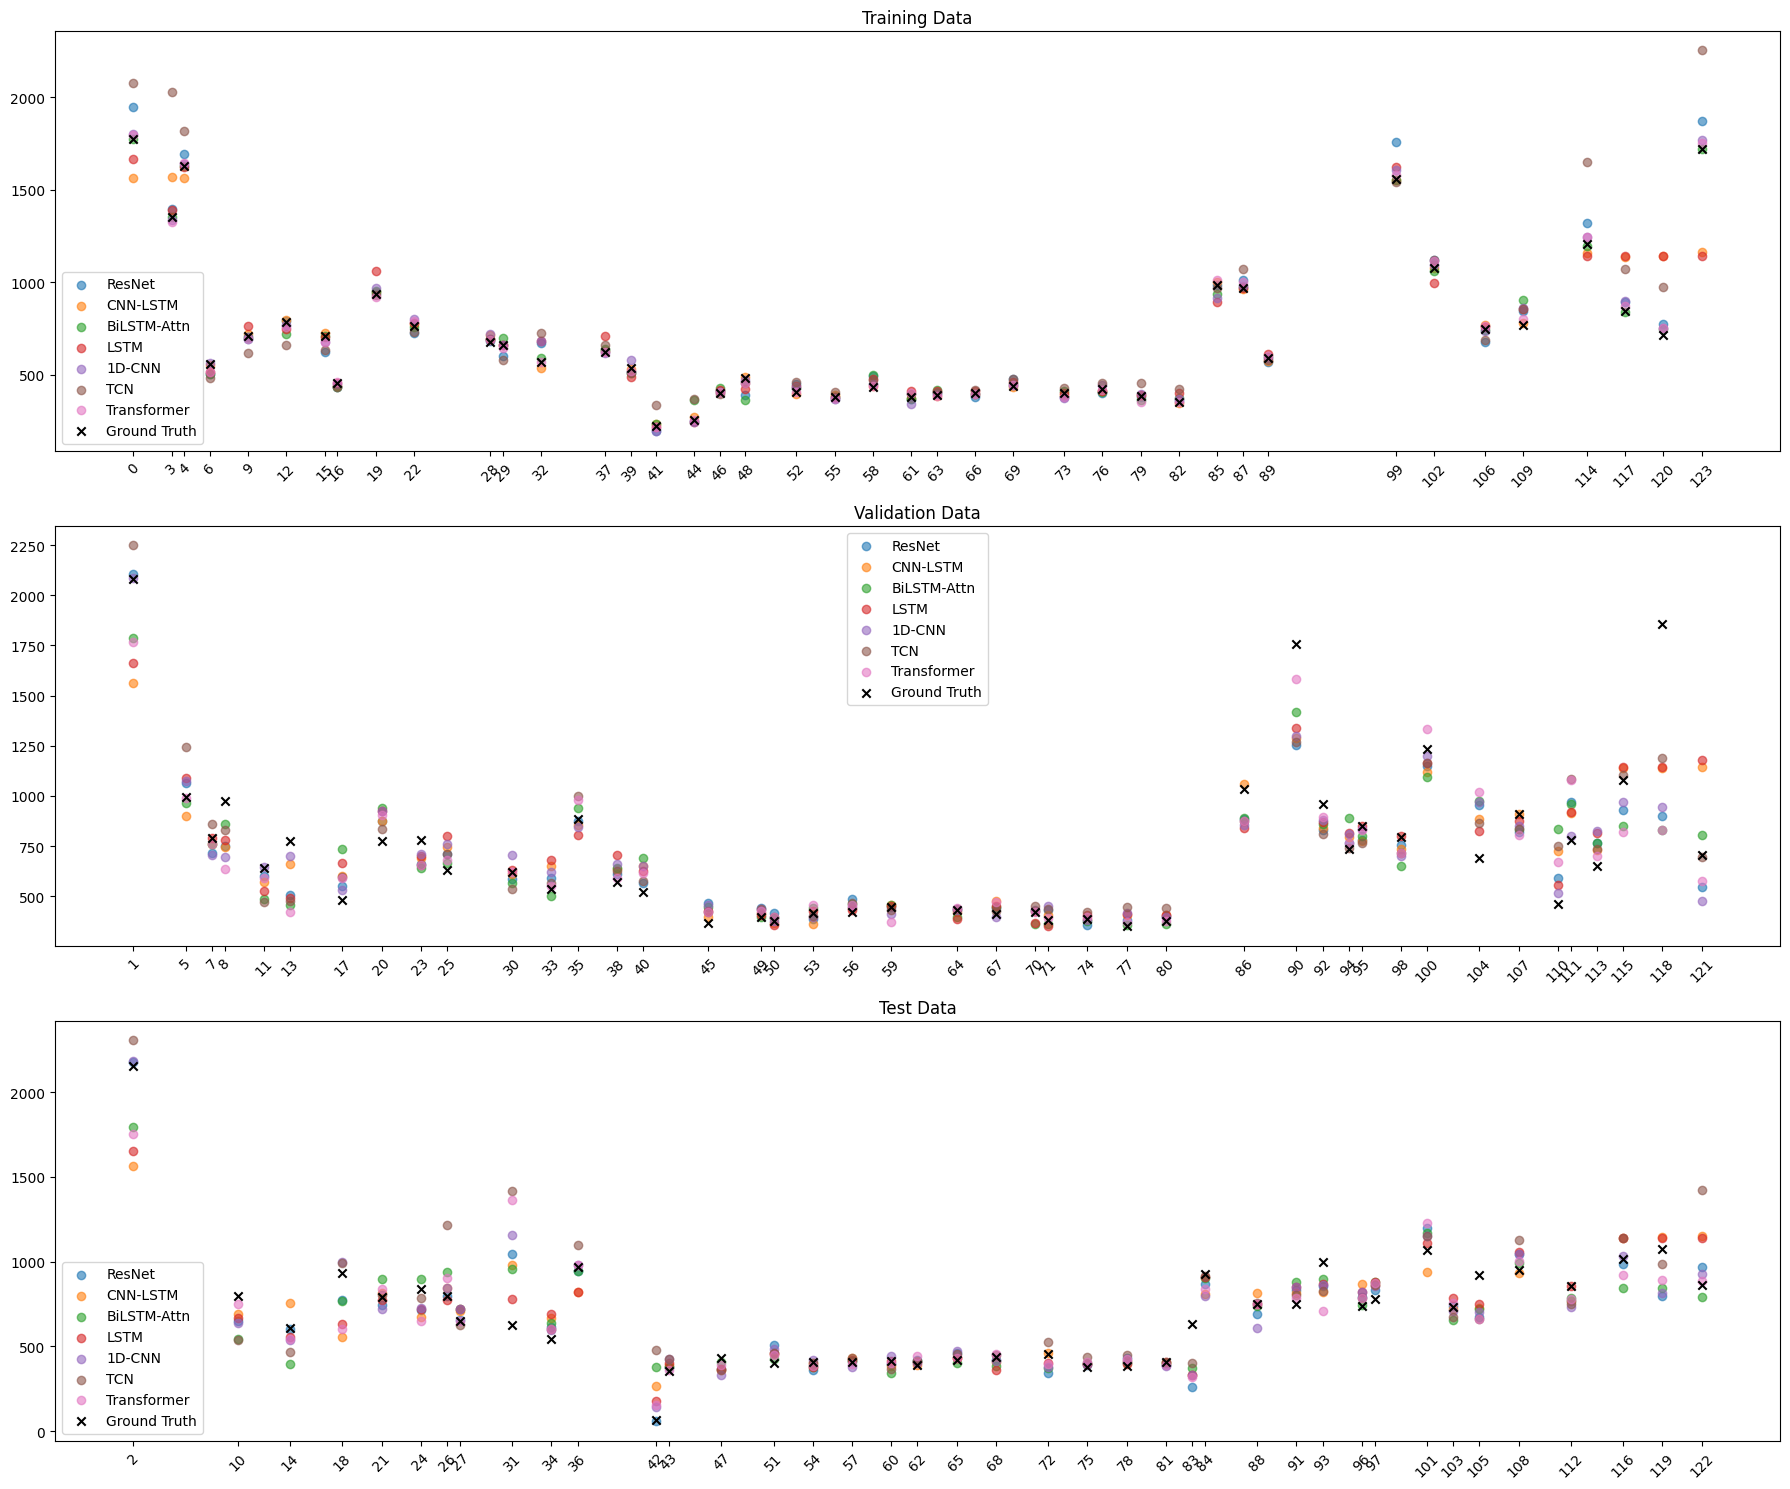

In [ ]:
def plot_all_scatter(train_preds, val_preds, test_preds, labels, indices_train, indices_val, indices_test):
    plt.figure(figsize=(18, 15))

    # Training data
    plt.subplot(3, 1, 1)
    for train_pred, label in zip(train_preds, labels):
        plt.scatter(indices_train, train_pred, label=label, alpha=0.6)
    plt.scatter(indices_train, y_train_norm, label='Ground Truth', color='black', marker='x')
    plt.title('Training Data')
    plt.xticks(indices_train, rotation=45)
    plt.legend()

    # Validation data
    plt.subplot(3, 1, 2)
    for val_pred, label in zip(val_preds, labels):
        plt.scatter(indices_val, val_pred, label=label, alpha=0.6)
    plt.scatter(indices_val, y_val_norm, label='Ground Truth', color='black', marker='x')
    plt.title('Validation Data')
    plt.xticks(indices_val, rotation=45)
    plt.legend()

    # Test data
    plt.subplot(3, 1, 3)
    for test_pred, label in zip(test_preds, labels):
        plt.scatter(indices_test, test_pred, label=label, alpha=0.6)
    plt.scatter(indices_test, y_test_norm, label='Ground Truth', color='black', marker='x')
    plt.title('Test Data')
    plt.xticks(indices_test, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

train_predictions = [train_pred_resnet, train_pred_cnnlstm, train_pred_bilstm_attn, train_pred_lstm, train_pred_1dcnn, train_pred_tcn, train_pred_transformer]
val_predictions = [val_pred_resnet, val_pred_cnnlstm, val_pred_bilstm_attn, val_pred_lstm, val_pred_1dcnn, val_pred_tcn, val_pred_transformer]
test_predictions = [test_pred_resnet, test_pred_cnnlstm, test_pred_bilstm_attn, test_pred_lstm, test_pred_1dcnn, test_pred_tcn, test_pred_transformer]
labels = ["ResNet", "CNN-LSTM", "BiLSTM-Attn", "LSTM", "1D-CNN", "TCN", "Transformer"]


plot_all_scatter(train_predictions, val_predictions, test_predictions, labels, indices_train, indices_val, indices_test)


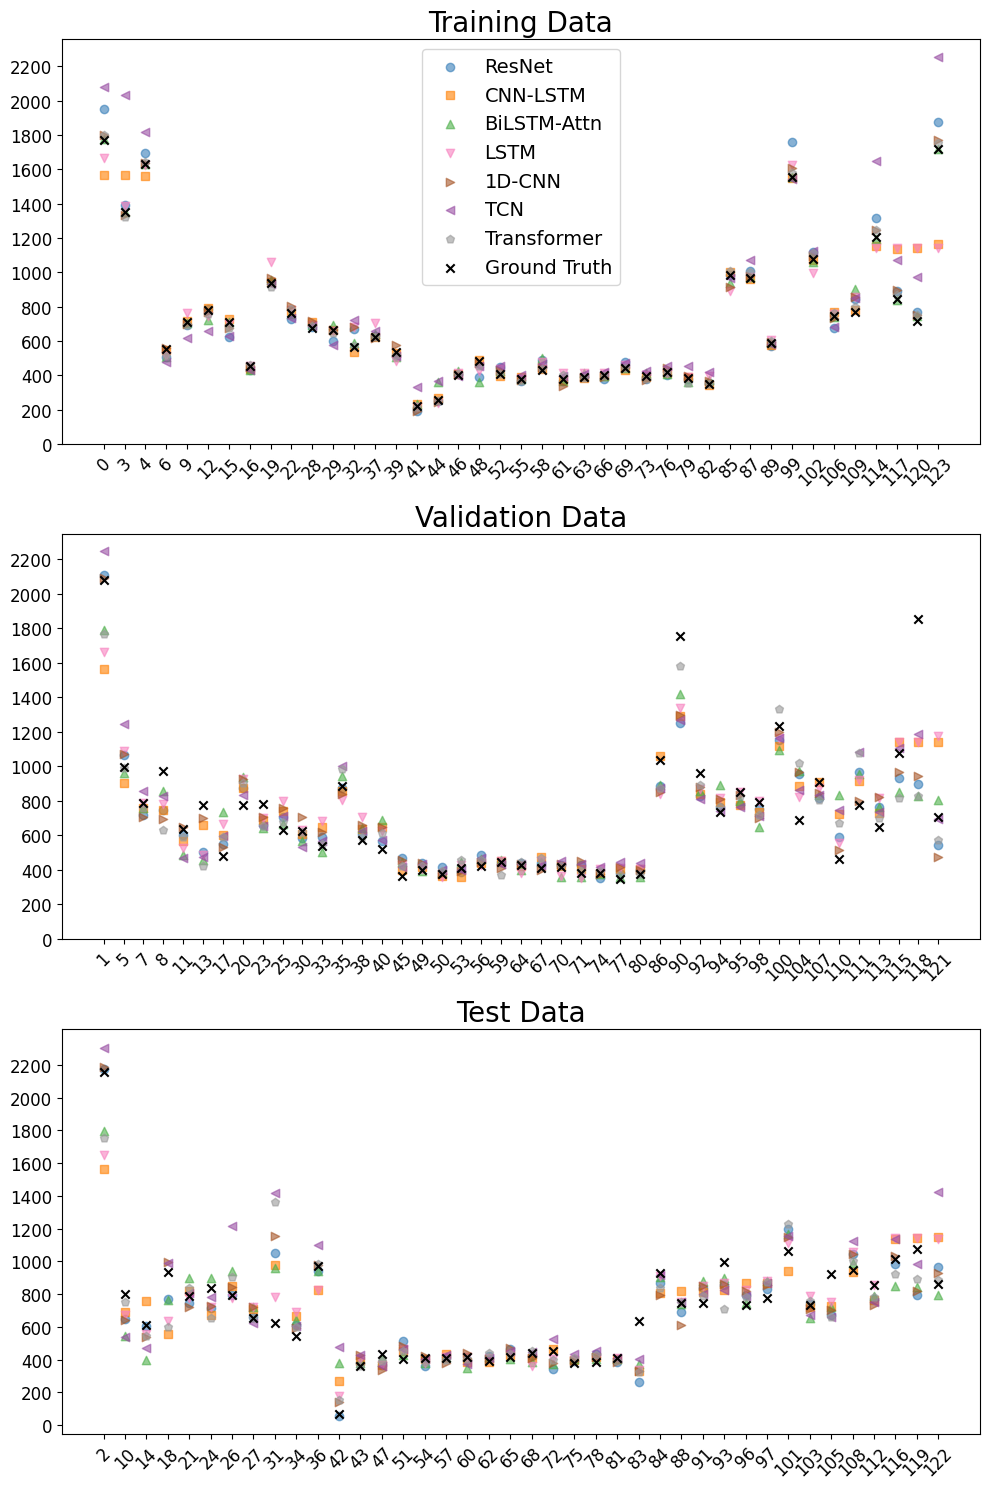

In [ ]:
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999']
markers = ['o', 's', '^', 'v', '>', '<', 'p']
interval = 200
ymin = 0
ymax = 2300

def plot_all_scatter(train_preds, val_preds, test_preds, labels, indices_train, indices_val, indices_test):
    plt.figure(figsize=(10, 15))

    # Training data
    plt.subplot(3, 1, 1)
    for idx, (train_pred, label) in enumerate(zip(train_preds, labels)):
        plt.scatter(range(len(indices_train)), train_pred, label=label, color=colors[idx], marker=markers[idx], alpha=0.6)
    plt.scatter(range(len(indices_train)), y_train_norm, label='Ground Truth', color='black', marker='x')
    plt.title('Training Data', fontsize=20)
    plt.xticks(range(len(indices_train)), indices_train, rotation=45, fontsize=12)
    #ymin, ymax = plt.gca().get_ylim()
    plt.yticks(np.arange(ymin, ymax, interval), fontsize=12)
    plt.legend(fontsize=14)

    # Validation data
    plt.subplot(3, 1, 2)
    for idx, val_pred in enumerate(val_preds):
        plt.scatter(range(len(indices_val)), val_pred, color=colors[idx], marker=markers[idx], alpha=0.6)
    plt.scatter(range(len(indices_val)), y_val_norm, color='black', marker='x')
    plt.title('Validation Data', fontsize=20)
    plt.xticks(range(len(indices_val)), indices_val, rotation=45, fontsize=12)
    #ymin, ymax = plt.gca().get_ylim()
    plt.yticks(np.arange(ymin, ymax, interval), fontsize=12)

    # Test data
    plt.subplot(3, 1, 3)
    for idx, test_pred in enumerate(test_preds):
        plt.scatter(range(len(indices_test)), test_pred, color=colors[idx], marker=markers[idx], alpha=0.6)
    plt.scatter(range(len(indices_test)), y_test_norm, color='black', marker='x')
    plt.title('Test Data', fontsize=20)
    plt.xticks(range(len(indices_test)), indices_test, rotation=45, fontsize=12)
    #ymin, ymax = plt.gca().get_ylim()
    plt.yticks(np.arange(ymin, ymax, interval), fontsize=12)

    plt.tight_layout()
    plt.show()


train_predictions = [train_pred_resnet, train_pred_cnnlstm, train_pred_bilstm_attn, train_pred_lstm, train_pred_1dcnn, train_pred_tcn, train_pred_transformer]
val_predictions = [val_pred_resnet, val_pred_cnnlstm, val_pred_bilstm_attn, val_pred_lstm, val_pred_1dcnn, val_pred_tcn, val_pred_transformer]
test_predictions = [test_pred_resnet, test_pred_cnnlstm, test_pred_bilstm_attn, test_pred_lstm, test_pred_1dcnn, test_pred_tcn, test_pred_transformer]
labels = ["ResNet", "CNN-LSTM", "BiLSTM-Attn", "LSTM", "1D-CNN", "TCN", "Transformer"]


plot_all_scatter(train_predictions, val_predictions, test_predictions, labels, indices_train, indices_val, indices_test)
